# <center>Занятие 24. Прогноз просрочки кредита заемщиком</center>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import validation_curve, learning_curve
RANDOM_STATE = 17

### Описание набора данных

Данные представляют собой исторические данные по 251503 заемщикам (https://www.kaggle.com/c/GiveMeSomeCredit/data ). Задача является бинарной классификацией. Цель - предсказать будет ли тот или иной заемщик испытывать финансовые трудности в ближайшие 2 года, т.е. будет ли просрочка по займу. Выборка разделена на тренировочную и тестовую ( 150000 в тренировочной части, 101503 в тестовой).

Данная решаемая задача будет ценна как кредиторам, так и заемщикам для оценки способности вернуть долг вовремя.

### Описание признаков

* 1 - __SeriousDlqin2yrs__ - будет ли просрочка более 90 дней в ближайшие 2 года (целевая метка) (Да/Нет)
* 2 - __RevolvingUtilizationOfUnsecuredLines__ - общий баланс по кредитным картам и кредитным линиям, за исключением задолженностей по недвижимости задолженности по взносам, деленные на сумму кредитных лимитов (проценты)
* 3 - __age__ - Возраст заемщика (в годах)
* 4 - __NumberOfTime30-59DaysPastDueNotWorse__ - количество просрочек в 30-59 дней (Целое)
* 5 - __DebtRatio__ - коэффициент задолженности, т.е. сумма ежемесячных платежей по долгам, алиментов и расходов на проживание, деленная на месячный доналоговый доход (проценты)
* 6 - __Monthly Income__ - месячный доход (число с плавающей точкой)
* 7 - __NumberOfOpenCreditLinesAndLoans__ - количество открытых кредитов и кредитных линий (Целое)
* 8 - __NumberOfTimes90DaysLate__ - количество просрочек более 90 дней (Целое)
* 9 - __NumberRealEstateLoansOrLines__ - количество ипотечных кредитов и кредитов на недвижимость, включая кредитные линии домашнего капитала (Целое)
* 10 - __NumberOfTime60-89DaysPastDueNotWorse__ - количество просрочек в 60-89 дней за последние 2 года (Целое)
* 11 - __NumberOfDependents__ - количество иждивенцев в семье (исключая самих заемщиков) (Целое)

In [2]:
def make_submission(predictions, fname):
    out = pd.DataFrame(data=predictions, columns=['Probability'])
    out.index += 1
    out.to_csv(fname, index_label='id')

In [3]:
df = pd.read_csv('cs-training.csv', index_col=0)
#df.dropna(axis=0, inplace=True)

In [4]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

Проверьте наличие категориальных признаков, а также соответствие содержимого данных их типам

In [5]:
list(set(df._get_numeric_data().columns)-set(df.columns))

[]

### I. Эксплоративный анализ. Проверяем значения по отдельным колонкам

##### 01. Проверим значения по колонке 'age'

In [6]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.age.value_counts()).sort_index()

,age
0,1
21,183
22,434
23,641
24,816
25,953
26,1193
27,1338
28,1560
29,1702


##### Удалим ту строку, где возраст равен '0', т.к. этот случай единичен.

In [7]:
pd.set_option('display.max_rows', 10)
df.loc[df.age==0].index[0] # вычисляем индекс строки, в которой возраст равен '0'
df.drop(df.loc[df.age==0].index[0], axis=0, inplace=True)

##### 02. Проверим значения по колонке 'NumberOfTime30-59DaysPastDueNotWorse'

In [8]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfTime30-59DaysPastDueNotWorse'].value_counts()).sort_index()

,NumberOfTime30-59DaysPastDueNotWorse
0,126018
1,16032
2,4598
3,1754
4,747
5,342
6,140
7,54
8,25
9,12


##### Вывод: Поскольку значения '96' и "98' в колонке 'NumberOfTime30-59DaysPastDueNotWorse' очень сильно отличаются от других. Можно предположить, что на самом деле это значения '06' и '08'. Поэтом поменяем их значения на '6' и '8' соответственно

In [9]:
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==96, 'NumberOfTime30-59DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime30-59DaysPastDueNotWorse']==98, 'NumberOfTime30-59DaysPastDueNotWorse']=8

##### 03. Проанализируем колонки 'DebtRatio' и 'MonthlyIncome' вместе (т.к. два параметра тесно связаны). Поскольку в колонке 'MonthlyIncome' есть NaN Значения, то заменим их на -1 чтобы можно было визуализировать все на графиках.

In [10]:
df.MonthlyIncome.fillna(-1, inplace=True)

<AxesSubplot:xlabel='MonthlyIncome', ylabel='DebtRatio'>

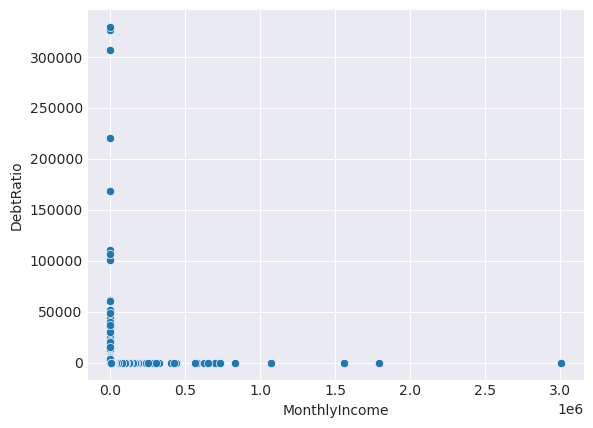

In [11]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df)

##### Построим график снова с ограничением по значению месячного дохода до 5

<AxesSubplot:xlabel='MonthlyIncome', ylabel='DebtRatio'>

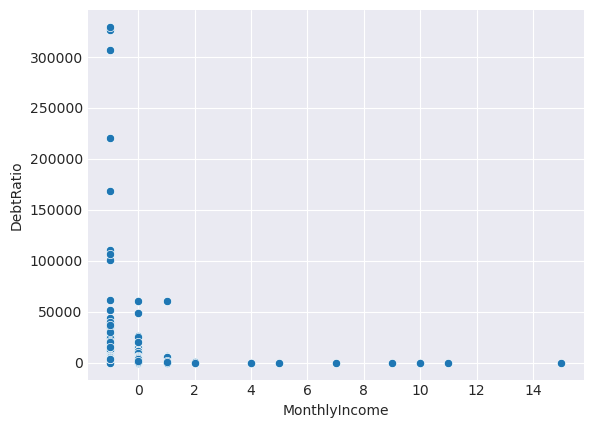

In [12]:
sns.scatterplot(x='MonthlyIncome',y='DebtRatio', data=df.loc[df.MonthlyIncome<20])

##### Посчитаем как распределяется DebtRatio в зависимости от дохода

In [13]:
pd.qcut(df.loc[df['MonthlyIncome']==-1, 'DebtRatio'],90, duplicates="drop").value_counts()

(-0.001, 1.0]           1827
(2.0, 5.0]               450
(7.0, 11.0]              417
(37.0, 44.0]             358
(22.0, 27.0]             353
(51.0, 60.0]             348
(31.0, 37.0]             347
(1761.0, 1816.0]         341
(297.0, 344.0]           338
(1006.0, 1056.0]         338
(81.0, 96.0]             337
(1353.0, 1398.0]         337
(598.333, 653.0]         336
(96.0, 113.0]            335
(1865.667, 1926.0]       335
(2038.667, 2105.0]       335
(168.0, 207.0]           335
(1446.0, 1493.0]         334
(2415.0, 2486.0]         334
(2817.333, 2910.0]       334
(1708.0, 1761.0]         334
(3010.0, 3114.0]         333
(1547.0, 1599.0]         332
(432.0, 473.0]           332
(653.0, 701.0]           332
(804.0, 858.0]           332
(1159.0, 1207.0]         332
(388.0, 432.0]           332
(2163.0, 2225.0]         332
(4166.667, 4416.0]       332
(1599.0, 1651.0]         331
(2352.0, 2415.0]         331
(2562.333, 2642.0]       331
(3463.333, 3604.0]       331
(5094.333, 558

##### Вывод: как видно из представленного графика и возможных значений DebtRatio - наиболее вероятно при N/A Значений имеется ввиду нулевой доход, т.к. DebtRatio значительно больше нуля в большинстве случаев, а такого не может быть, человеку не могут выдать кредитов больше, чем он может погасить. Значит наиболее оправданным подходом является: для тех случаев, где DebtRatio <1 заполнить N/A медианным значением по колонке, в остальных случаях присвоить значение 0.

In [14]:
df.loc[(df.MonthlyIncome==-1)&(df.DebtRatio<1), 'MonthlyIncome']=df.MonthlyIncome.median()
df.loc[df['MonthlyIncome']==-1, 'MonthlyIncome']=0

##### 04. Проверим значения по колонке 'NumberOfTimes90DaysLate'

In [15]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df.NumberOfTimes90DaysLate.value_counts()).sort_index()

,NumberOfTimes90DaysLate
0,141661
1,5243
2,1555
3,667
4,291
5,131
6,80
7,38
8,21
9,19


##### Как и для 'NumberOfTime30-59DaysPastDueNotWorse' заменим и тут значения 96 и 98 на 6 и 8

In [16]:
df.loc[df['NumberOfTimes90DaysLate']==96, 'NumberOfTimes90DaysLate']=6
df.loc[df['NumberOfTimes90DaysLate']==98, 'NumberOfTimes90DaysLate']=8

##### 05 Для NumberOfTime60-89DaysPastDueNotWorse тоже самое. Замени 96 и 98 на 6 и 8

In [17]:
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==96, 'NumberOfTime60-89DaysPastDueNotWorse']=6
df.loc[df['NumberOfTime60-89DaysPastDueNotWorse']==98, 'NumberOfTime60-89DaysPastDueNotWorse']=8

##### 06. Проверим значения NumberOfDependents

In [18]:
pd.set_option('display.max_rows', None)
pd.DataFrame(df['NumberOfDependents'].value_counts())

,NumberOfDependents
0.0,86902
1.0,26316
2.0,19521
3.0,9483
4.0,2862
5.0,746
6.0,158
7.0,51
8.0,24
10.0,5


In [19]:
pd.set_option('display.max_rows', 10)

##### Вывод: Заполним пропуски медианным значением

In [20]:
df.NumberOfDependents.fillna(df.NumberOfDependents.median(), inplace=True)

##### 07. Поищем дубликаты в сете

In [21]:
sum(df.duplicated())

768

##### Удалим дубликаты

In [22]:
df.drop(df.loc[df.duplicated()].index, axis=0, inplace=True)

##### 08. Оцените количество вернувших и не вернувших кредит. Какую метрику лучше всего использовать?

In [23]:
df.SeriousDlqin2yrs.value_counts()

0    139227
1     10004
Name: SeriousDlqin2yrs, dtype: int64

##### Вывод: Поскольку сет несбалансированный, то здесь плохо применима метрика Accuracy. Возможно использовать Precision, Recall, F-меру, ROC-AUC

### II. Визуализируем сет.

##### 01. Используя  seaborn.pairplot (sns) визуализируйте данные (Учитывая ресурсозатратность данного графика возьмем из исходного набора лишь часть случаев, при этом сохранив изначальную пропорцию возвратов и невозвратов)

In [30]:
df_short = pd.concat([df.loc[df.SeriousDlqin2yrs==0][:100], #100 первых случаев с возвратом кредита
                      df.loc[df.SeriousDlqin2yrs==1][:10]], #10 первых с невозвратом
                     axis=0)

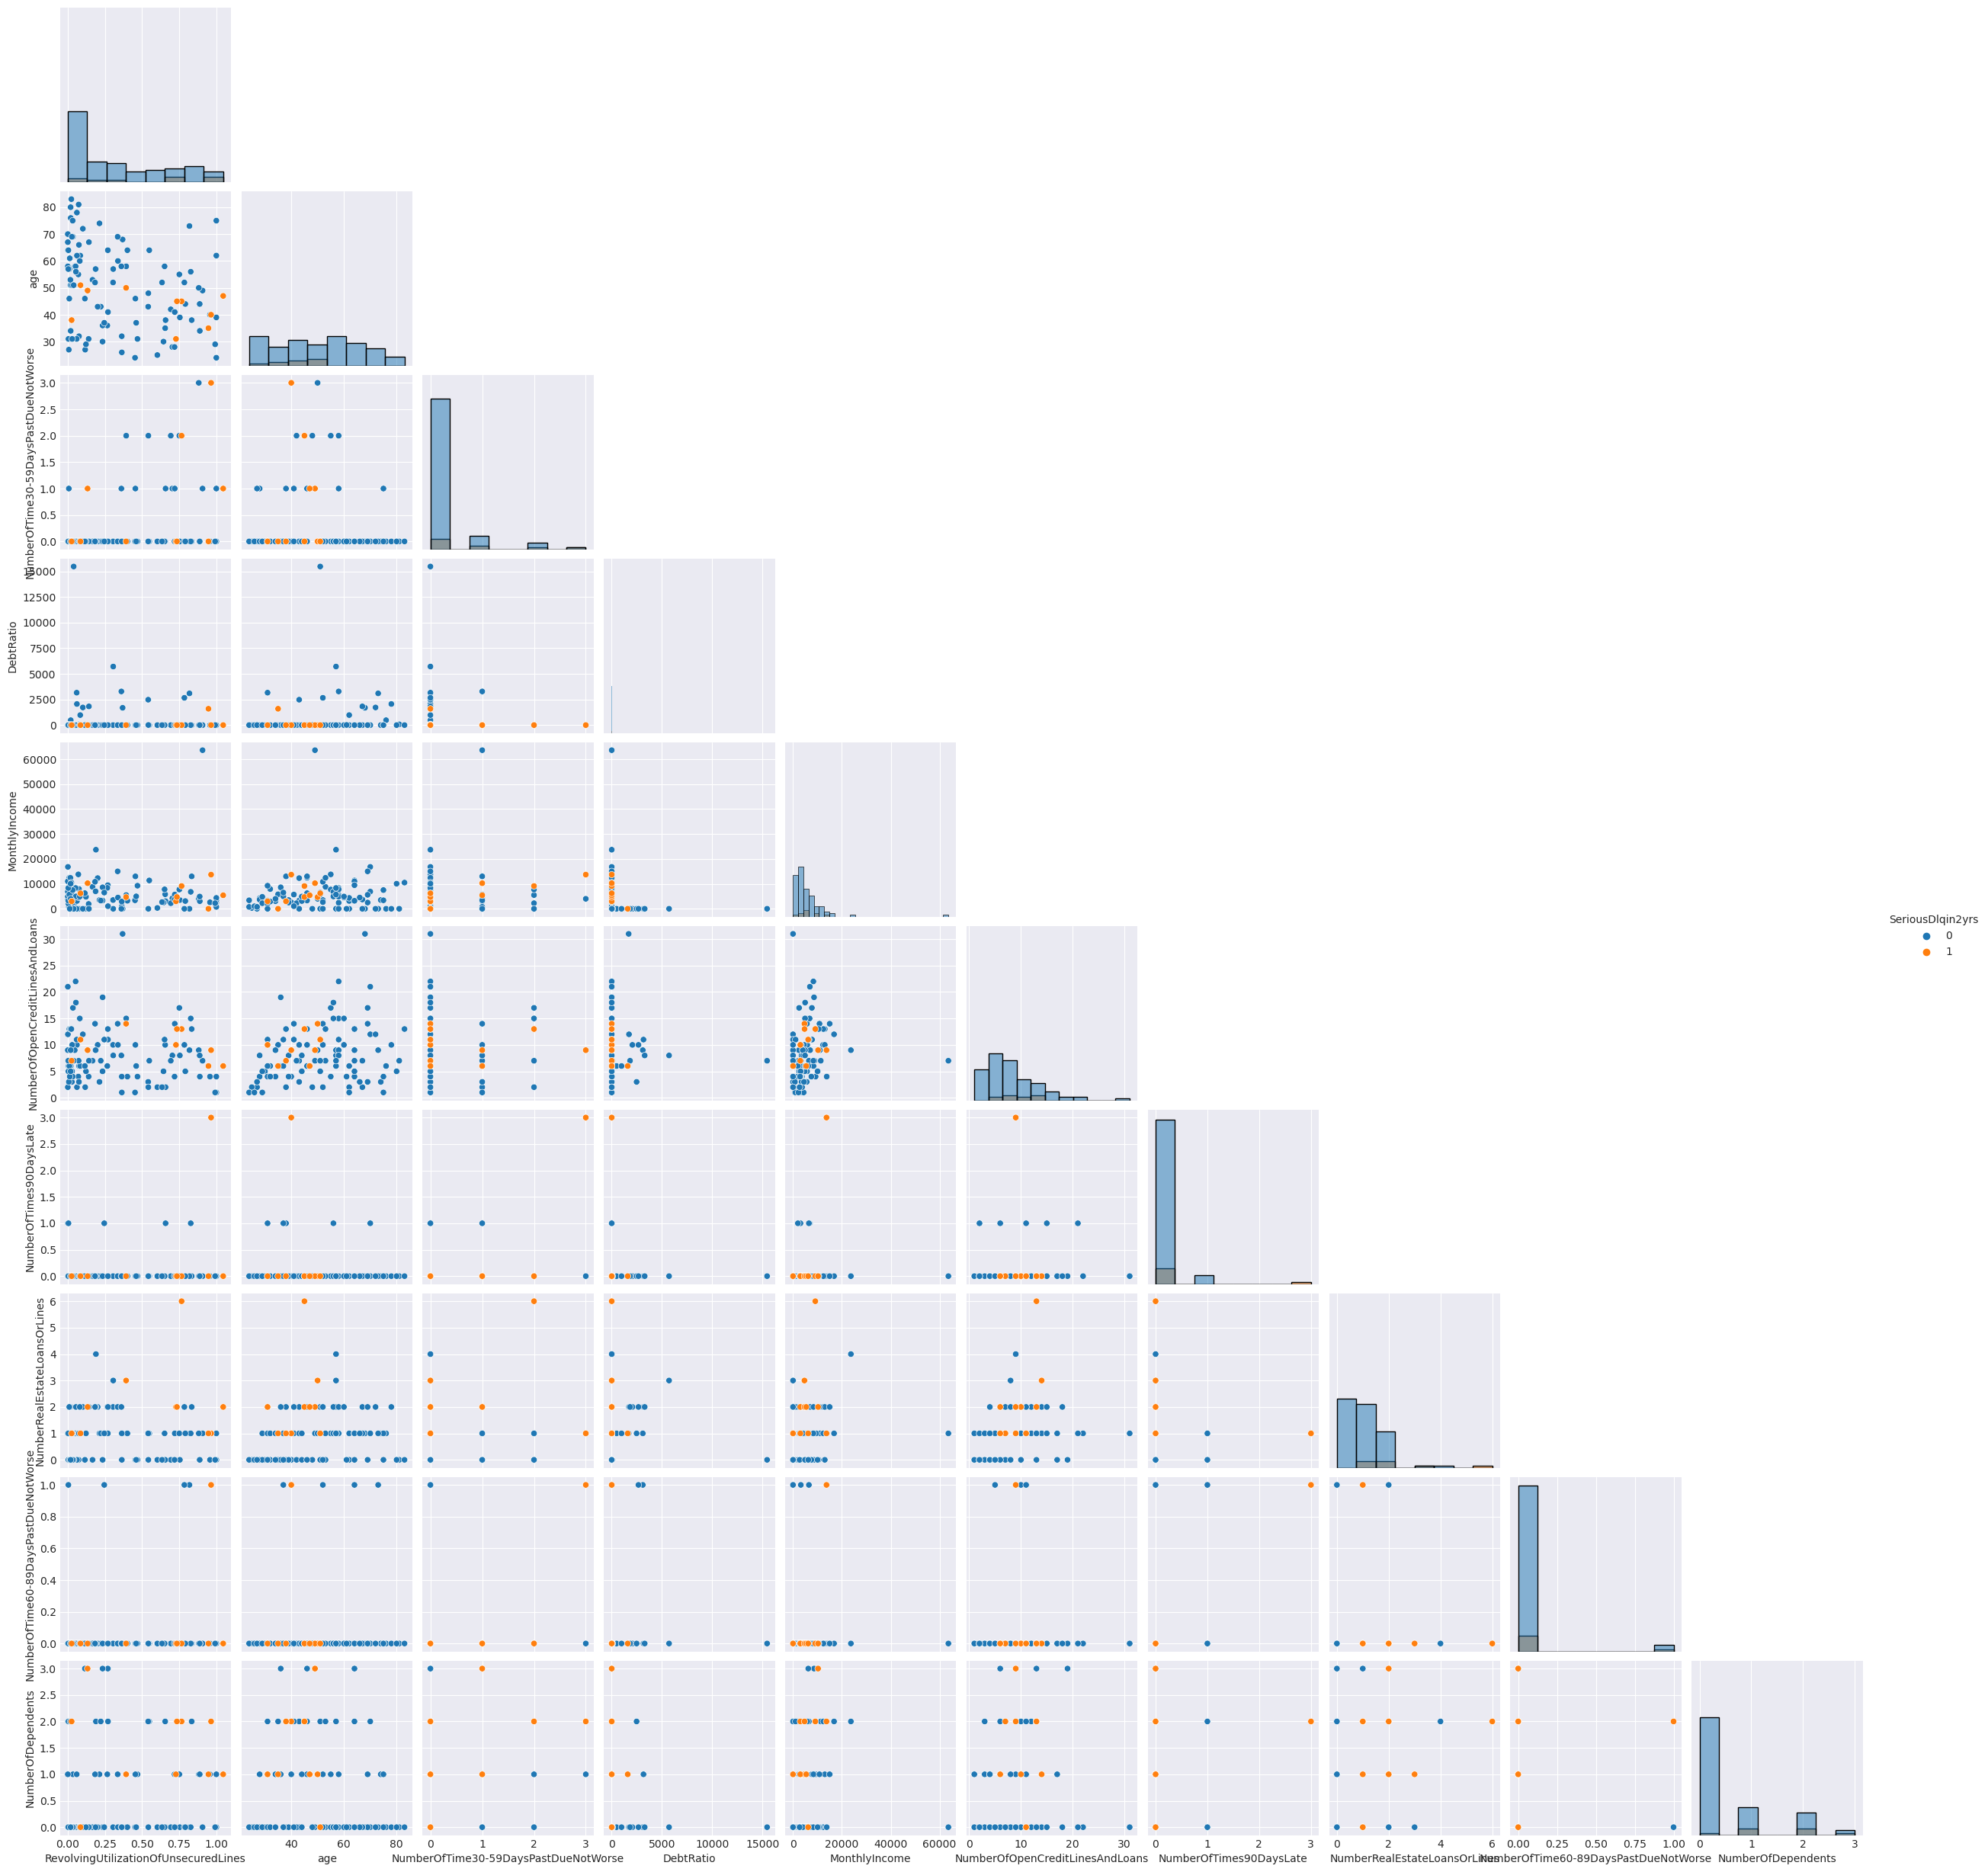

In [31]:
sns.pairplot(df_short,
           hue="SeriousDlqin2yrs", 
            diag_kind="hist",
            corner=True)

##### 02. Используя sns.heatmap постройте корреляционную матрицу

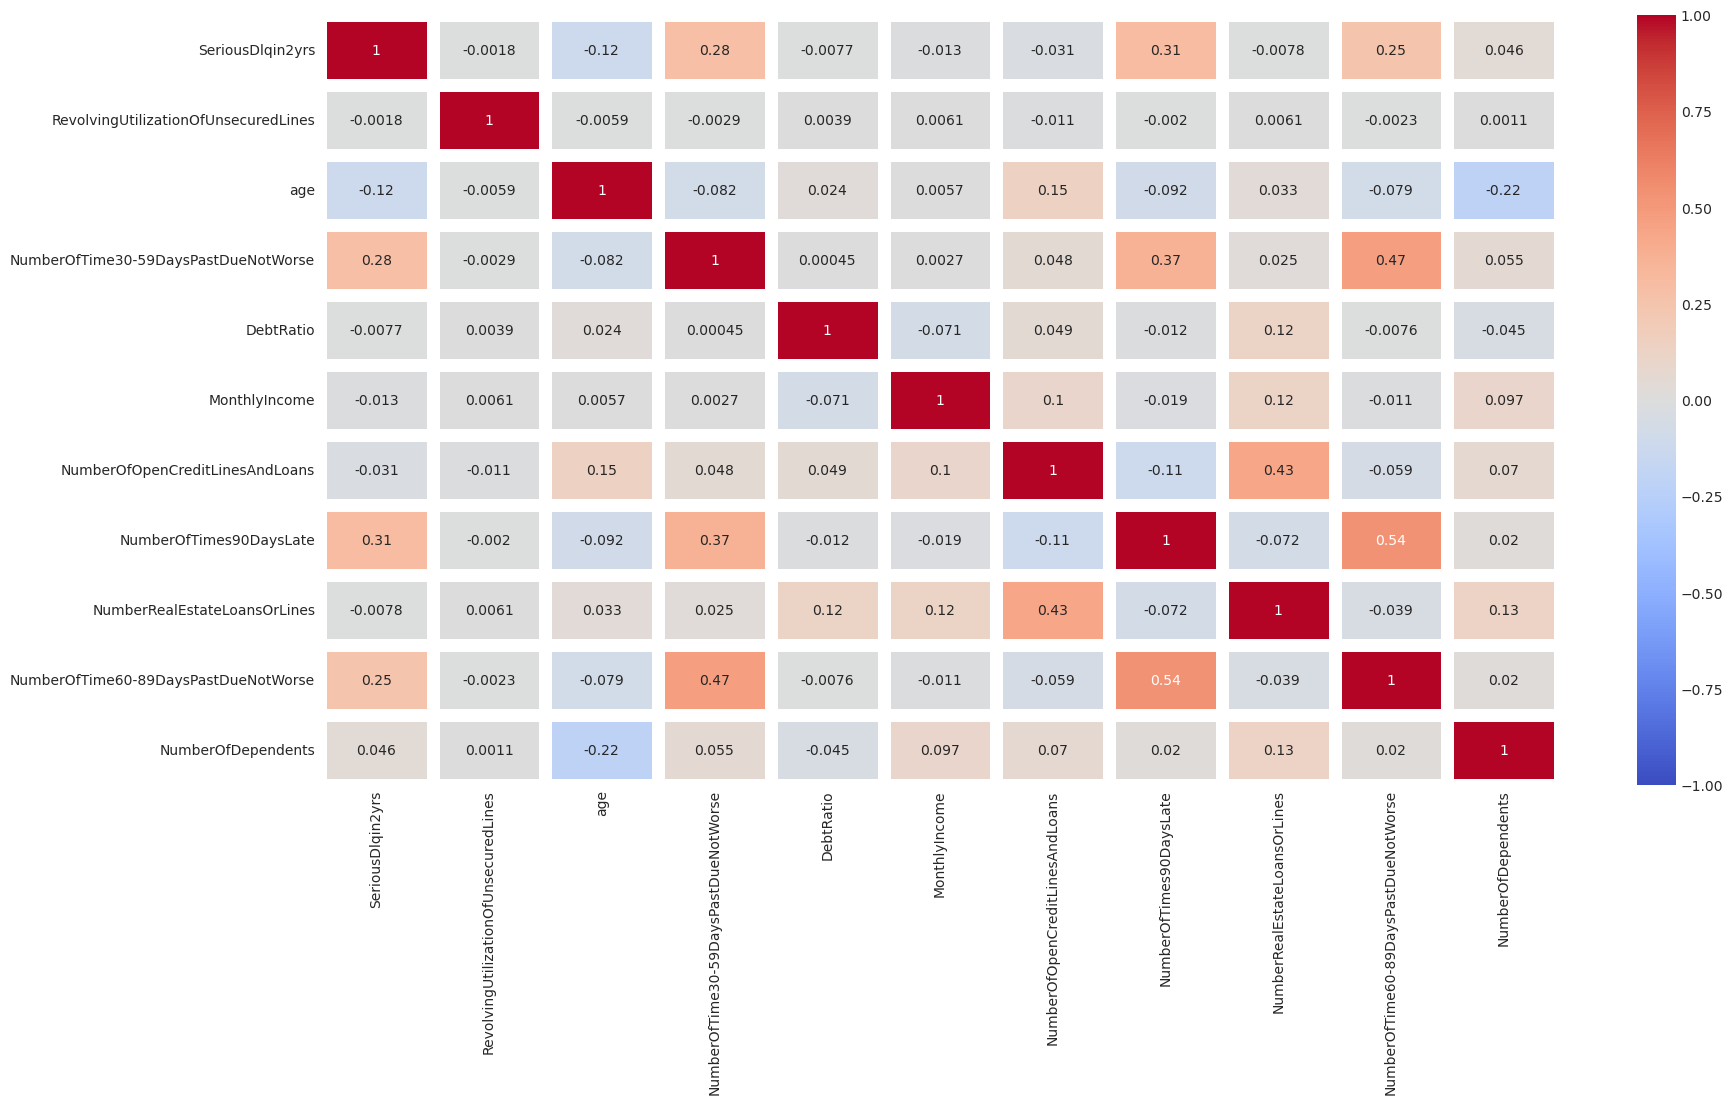

In [820]:
plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),
            annot=True, 
            vmin=-1, vmax=1, 
            center= 0, 
            cmap= 'coolwarm', 
            linewidths=9, 
            linecolor='white', 
            cbar_kws= {'orientation': 'vertical'});

Какие существуют зависимости в данных?
Опишите зависимости каждого из признаков!

Корелляцию можно видеть среди двух групп признаков:

* 1. __NumberOfTimes90DaysLate, NumberOfTime60-89DaysPastDueNotWorse, NumberOfTime30-59DaysPastDueNotWorse__
* 2. __NumberOfOpenCreditLinesAndLoans и NumberRealEstateLoansOrLines__

Что может говорить о том, что:
1) Клиент, который просрочил выплату на 30-59 дней, просрочит ее и на 60-89 и на 90 дней.

2) Кредит на квартиру уже входит в признак "Число открытых кредитов"


__Однако, их удаление ни к чему хорошему не привело. Метрики обучения падают на 6-7 процентов. Поэтому колонки эти все оставил__

##### 03. Визуализация связи дохода и невозвратов.

<AxesSubplot:xlabel='MonthlyIncome', ylabel='count'>

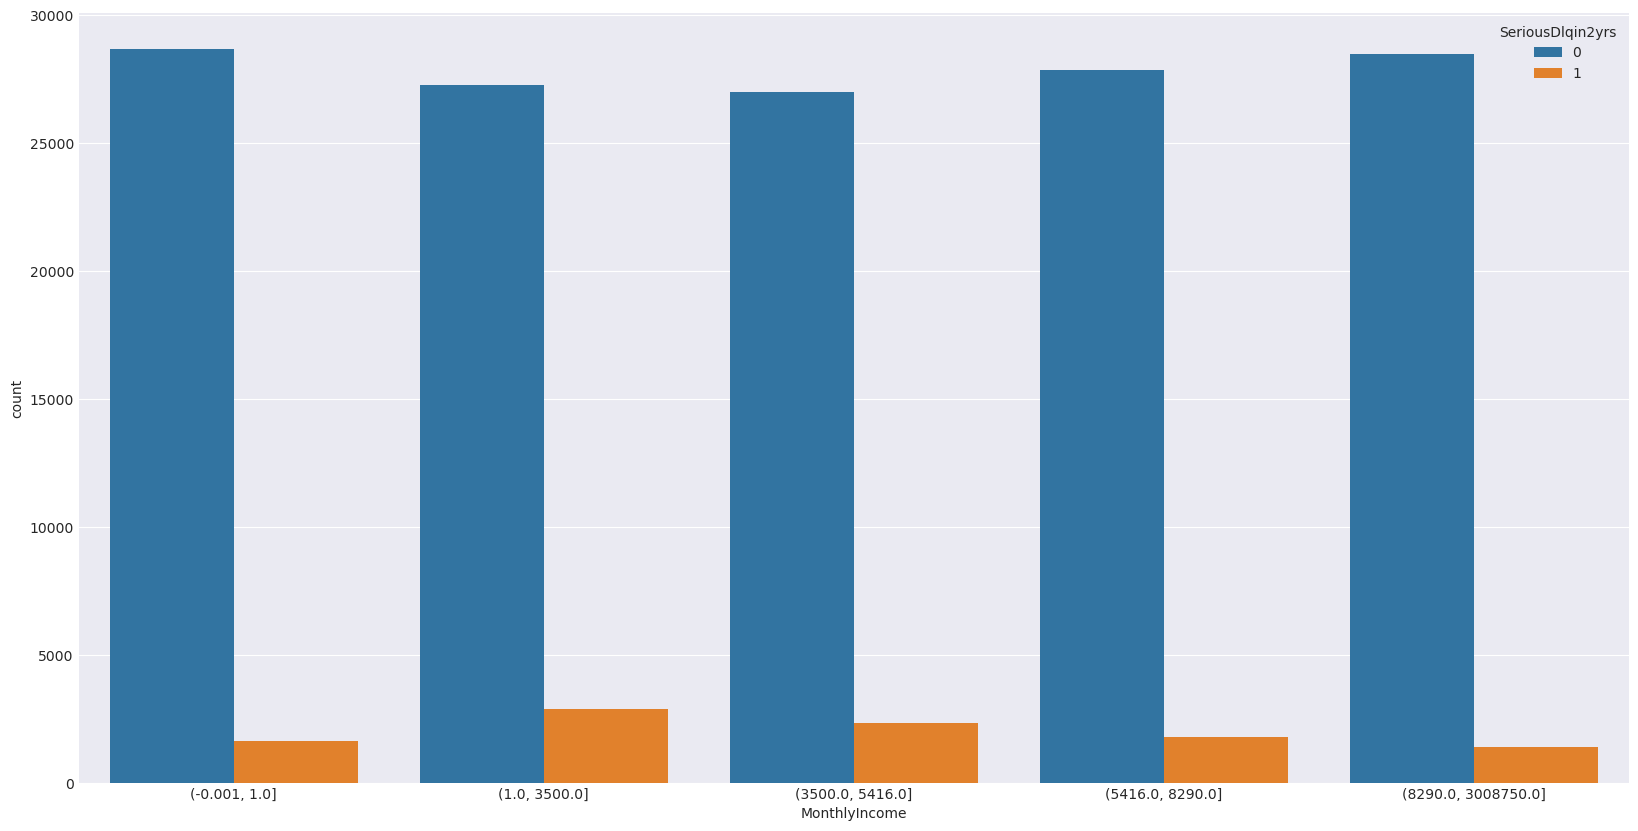

In [821]:
income_binned = income_binned = pd.qcut (df.MonthlyIncome, 5, duplicates='drop')

plt.figure(figsize=(20,10))
sns.countplot (x=income_binned, hue=df.SeriousDlqin2yrs)

#### Вывод: Данный график отражает интересную связь. Те люди, которые имеют в настоящий момент фактически нулевой доход (вероятно в результате потери работы) имеют меньшее количество невозвратов, нежели те, кто хронически мало зарабатывает. Далее количество невозвратов падает по мере роста доходов

### III. Обучение

In [822]:
X=df.drop('SeriousDlqin2yrs',axis=1)
y=df['SeriousDlqin2yrs']

##### 01. Обучите 2 классификатора логистическую регрессию и случайный лес. Для визуализации процесса обучения используйте прогрессбар tqdm

In [823]:
def model_training (model, X,y, scaler, nsplits=5):
    skf=StratifiedKFold(n_splits=nsplits, shuffle=True) # Данный метод выбран из-за несбалансированности сета  
    split=1
    all_ras=[]
    for train_index, test_index in tqdm(skf.split(X, y), 
                                        total=nsplits, 
                                        desc='Learning process'):
        X_train = scaler.fit_transform(X.iloc[train_index])
        y_train = y.iloc [train_index]
        X_test = scaler.fit_transform(X.iloc[test_index])
        y_test = y.iloc [test_index]
        model.fit(X_train, y_train)
        ras = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        print ('Model name: {}. Split №{}. ROC AUC score {}'.format(model, split, ras))
        all_ras.append(ras)
        split+=1
        
    print ('\tMinimal ROC-AUC score for this parametrs is {}\n\
            Maximal - {}\n\
            Difference Min-Max - {}\n\
            Mean - {}'.format(min(all_ras), 
                             max(all_ras),
                             max(all_ras)-min(all_ras),
                             sum(all_ras)/len(all_ras)))

In [824]:
lr=LogisticRegression()
sds=StandardScaler()
model_training (lr,X,y,sds)

Learning process:   0%|          | 0/5 [00:00<?, ?it/s]

Model name: LogisticRegression(). Split №1. ROC AUC score 0.8004613831847274
Model name: LogisticRegression(). Split №2. ROC AUC score 0.8139503780162353
Model name: LogisticRegression(). Split №3. ROC AUC score 0.8096689579433661
Model name: LogisticRegression(). Split №4. ROC AUC score 0.8155474785501845
Model name: LogisticRegression(). Split №5. ROC AUC score 0.8037246732026144
	Minimal ROC-AUC score for this parametrs is 0.8004613831847274
            Maximal - 0.8155474785501845
            Difference Min-Max - 0.01508609536545713
            Mean - 0.8086705741794254


In [825]:
rfc=RandomForestClassifier()
model_training(rfc, X,y, sds)

Learning process:   0%|          | 0/5 [00:00<?, ?it/s]

Model name: RandomForestClassifier(). Split №1. ROC AUC score 0.815937296380898
Model name: RandomForestClassifier(). Split №2. ROC AUC score 0.8245338724065873
Model name: RandomForestClassifier(). Split №3. ROC AUC score 0.7929337629622969
Model name: RandomForestClassifier(). Split №4. ROC AUC score 0.7546767198192966
Model name: RandomForestClassifier(). Split №5. ROC AUC score 0.8105450423759247
	Minimal ROC-AUC score for this parametrs is 0.7546767198192966
            Maximal - 0.8245338724065873
            Difference Min-Max - 0.06985715258729064
            Mean - 0.7997253387890007


##### 02. Оцените среднюю правильность выбранной модели

##### Вывод: Средняя метрика для Логистической регрессии получилась в 80.86, для дерева решений  79,97 

##### 03. Произведите подбор параметров. Для логистической регрессии подберем коэффициент регуляризции, для случайного леса -максимальную глубину и максимальное кол-во признаков. Для отслеживания процесса обучения используйте прогрессбар, а также %%time

##### 03.1. Логистическая регрессия

In [826]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [827]:
parameters = {"C":np.logspace(-3,3,7)}
pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(lr,parameters,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.935 total time=   0.1s
[CV 2/5] END ...........................C=0.001;, score=0.935 total time=   0.2s
[CV 3/5] END ...........................C=0.001;, score=0.935 total time=   0.2s
[CV 4/5] END ...........................C=0.001;, score=0.936 total time=   0.8s
[CV 5/5] END ...........................C=0.001;, score=0.935 total time=   1.2s
[CV 1/5] END ............................C=0.01;, score=0.936 total time=   1.8s
[CV 2/5] END ............................C=0.01;, score=0.936 total time=   1.0s
[CV 3/5] END ............................C=0.01;, score=0.935 total time=   0.3s
[CV 4/5] END ............................C=0.01;, score=0.936 total time=   0.2s
[CV 5/5] END ............................C=0.01;, score=0.936 total time=   0.2s
[CV 1/5] END .............................C=0.1;, score=0.936 total time=   0.2s
[CV 2/5] END .............................C=0.1;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                              verbose=3))])

In [828]:
pipeline.named_steps['gs'].best_params_

{'C': 1.0}

In [829]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])


0.8076377156003182

##### 03.2. Случайный лес

In [830]:
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,4]
}

pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(rfc,param_grid,cv=5,verbose=3)
                     )])


pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   9.3s
[CV 2/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   8.3s
[CV 3/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=  10.1s
[CV 4/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   9.3s
[CV 5/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   9.1s
[CV 1/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   9.6s
[CV 2/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   9.1s
[CV 3/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   8.3s
[CV 4/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   5.8s
[CV 5/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   9.6s
[CV 1/5] END ....max_depth=1, max_features=log2;, score=0.932 total time=   9.1s
[CV 2/5] END ....max_depth=1, max_features=log2;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'max_depth': [1, 2, 4],
                                          'max_features': ['auto', 'sqrt',
                                                           'log2']},
                              verbose=3))])

In [831]:
pipeline.named_steps['gs'].best_params_

{'max_depth': 4, 'max_features': 'sqrt'}

In [832]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.8551162818475432

#### Вывод: Лучший результат демонстрирует RandomForestClassifier() с максимальной глубиной 10 и max_features - auto - 85.51

### IV. __Создание новых признаков__

1. Выберите признаки подлежащие бинаризации.
2. Осуществите бинаризацию.
3. Как влияет количество интервалов бинаризации на качество модели? 

Для создания новых признаков рекомендую ответить на следующие вопросы:
Как влияют количество иждевенцев у заемщика на просрочку выплат?
Какой тип кредитов чаще всего берет заемщик?

#### 01. Оценим количество кредитов по количеству лиц на иждивении

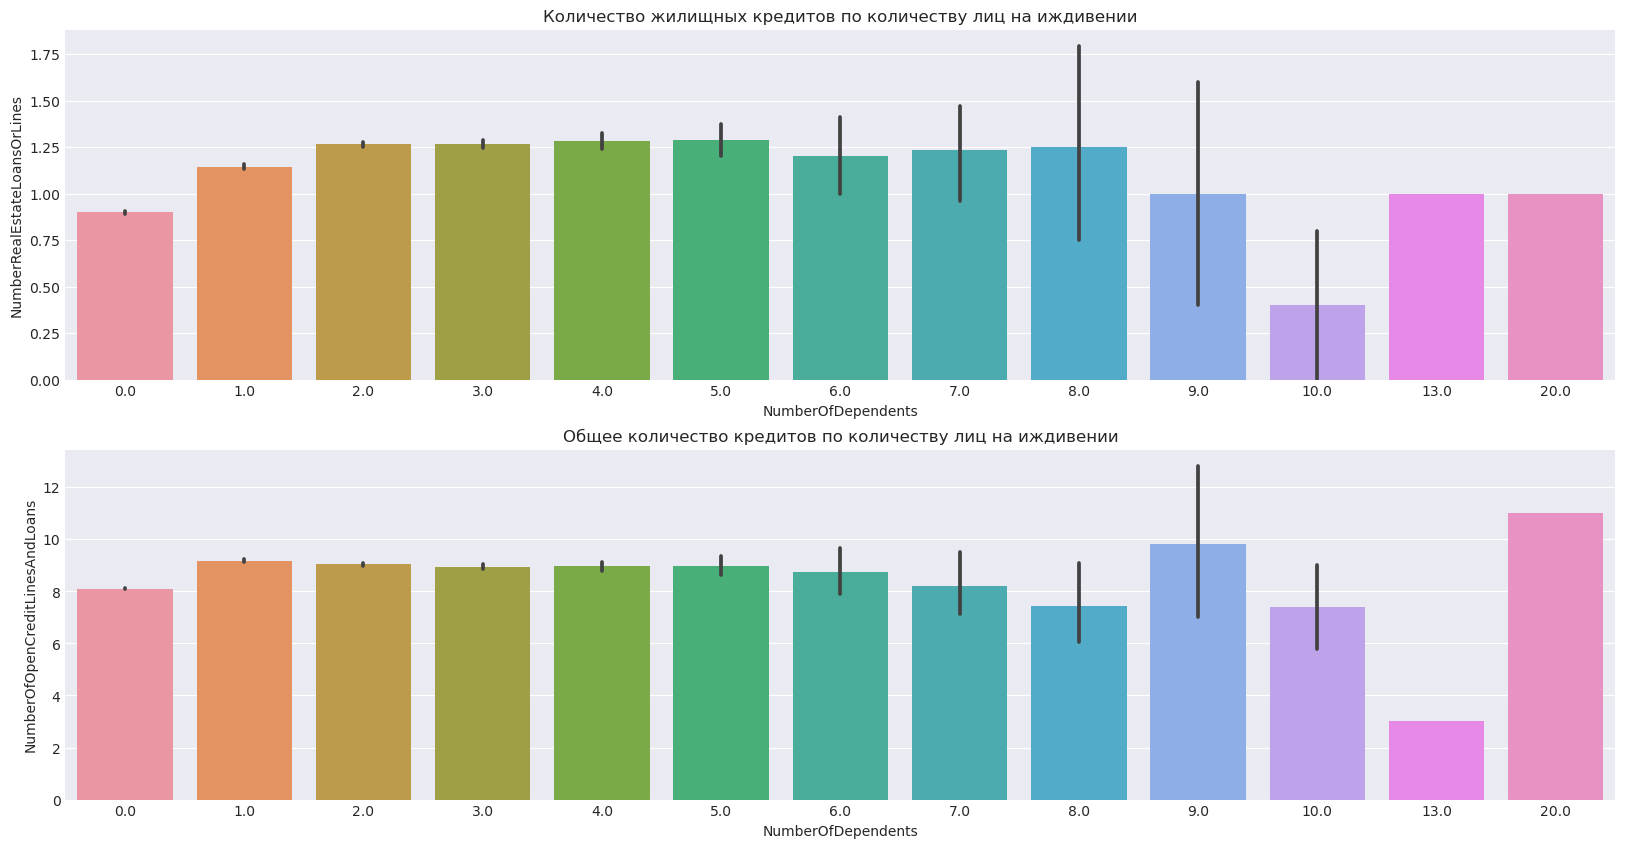

In [833]:
plt.figure(figsize=(20,10))


plt.subplot (2,1,1)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberRealEstateLoansOrLines');
plt.title ('Количество жилищных кредитов по количеству лиц на иждивении');

plt.subplot (2,1,2)
sns.barplot(data=df, x=df.NumberOfDependents, y='NumberOfOpenCreditLinesAndLoans');
plt.title ('Общее количество кредитов по количеству лиц на иждивении');

#### Вывод: у лиц без или с 9 иждивенцами и более меньше всего кредитов на жилье. А у лиц с 9 и 20 иждивенцами больше всего других кредитов.

#### 02. Оценим количество просрочек в зависимости от числа лиц на иждивении после разбития на группы

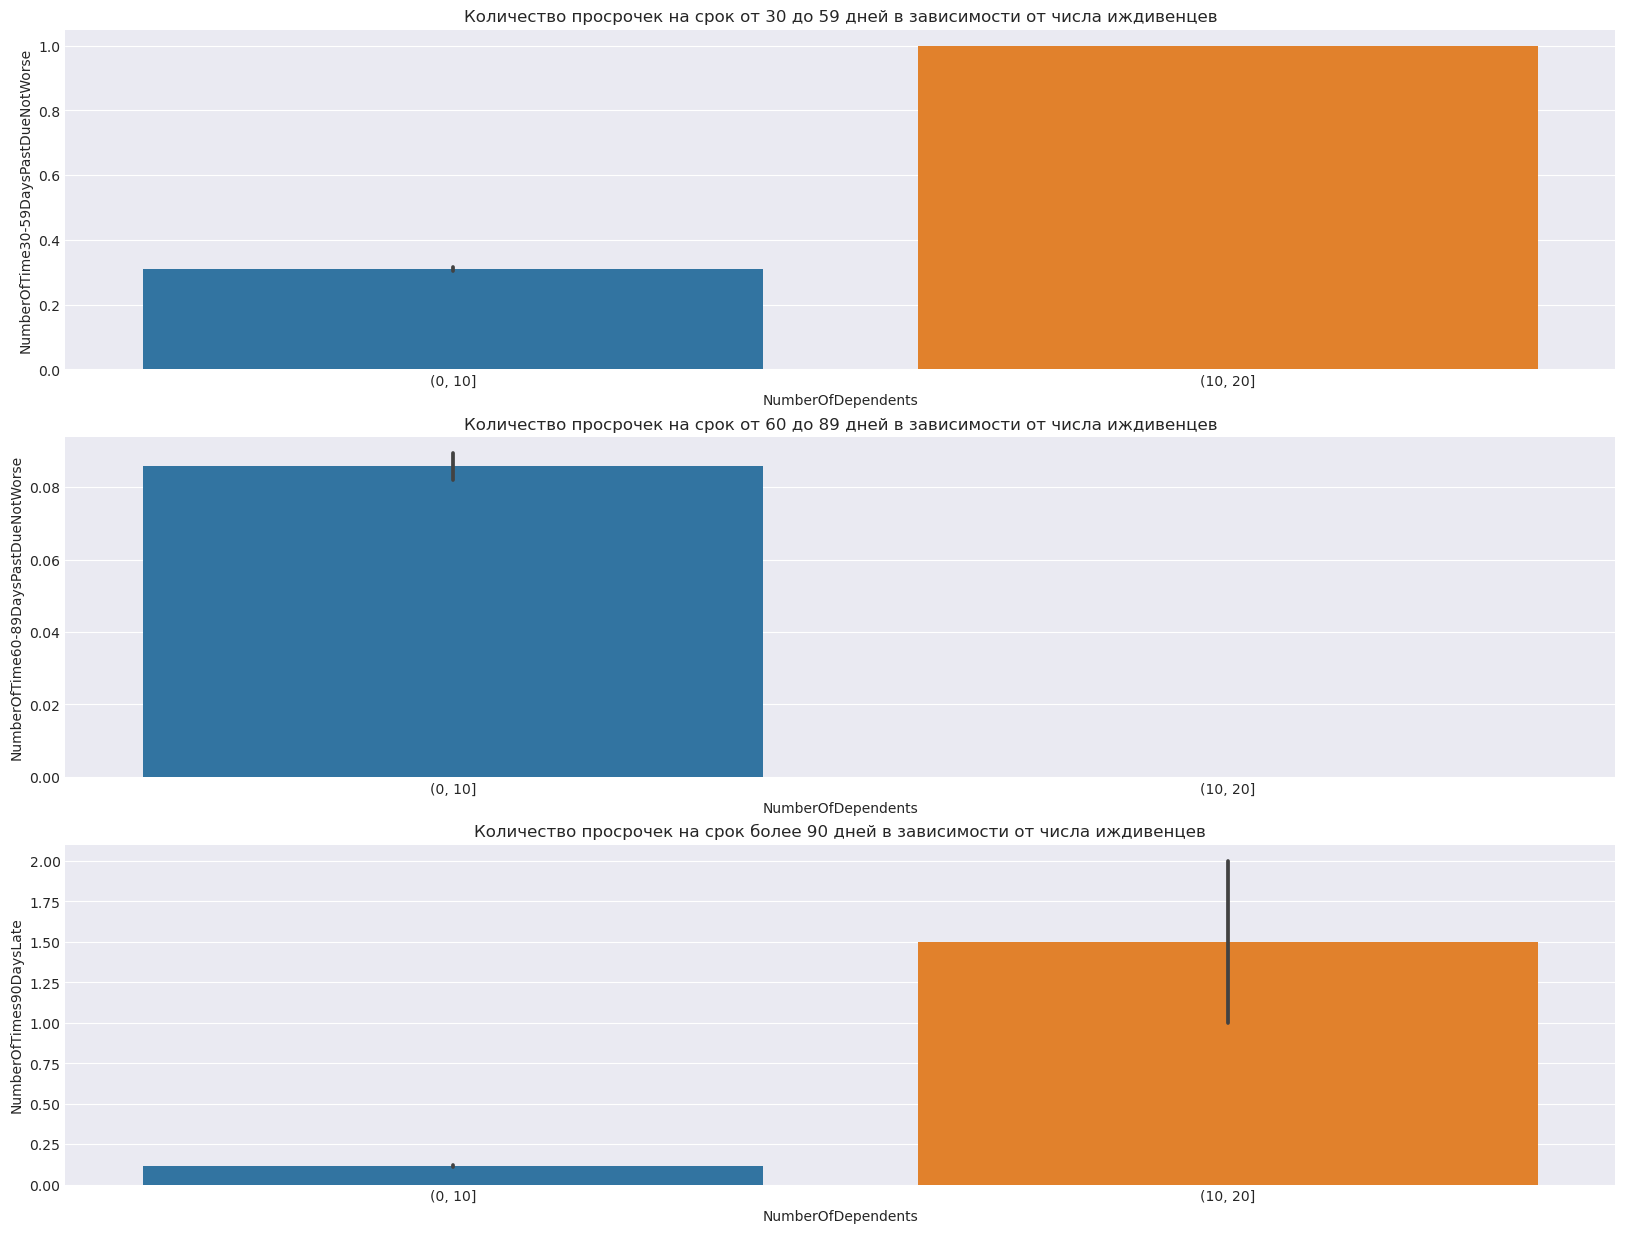

In [834]:
plt.figure(figsize=(20,15))

binned_val = pd.cut(df.NumberOfDependents, 
                   bins = [0,10,20])

plt.subplot (3,1,1)
sns.barplot(data=df, x=binned_val, y='NumberOfTime30-59DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 30 до 59 дней в зависимости от числа иждивенцев');


plt.subplot (3,1,2)
sns.barplot(data=df, x=binned_val, y='NumberOfTime60-89DaysPastDueNotWorse')
plt.title ('Количество просрочек на срок от 60 до 89 дней в зависимости от числа иждивенцев');

plt.subplot (3,1,3)
sns.barplot(data=df, x=binned_val, y='NumberOfTimes90DaysLate')
plt.title ('Количество просрочек на срок более 90 дней в зависимости от числа иждивенцев');

##### Итог: Исходя из представленных графиков я бы разбил все случаи на 2 группы: 0-10 - Группа 1, 11-20 - Группа 2

In [835]:
df.loc[(df.NumberOfDependents>=0) & (df.NumberOfDependents<=10), 'BinNumberOfDependents']=1
df.loc[(df.NumberOfDependents>=11), 'BinNumberOfDependents']=2

#### 03. Оценим общее количество открытых кредитных линий общих и по недвижимости

<AxesSubplot:xlabel='NumberRealEstateLoansOrLines', ylabel='count'>

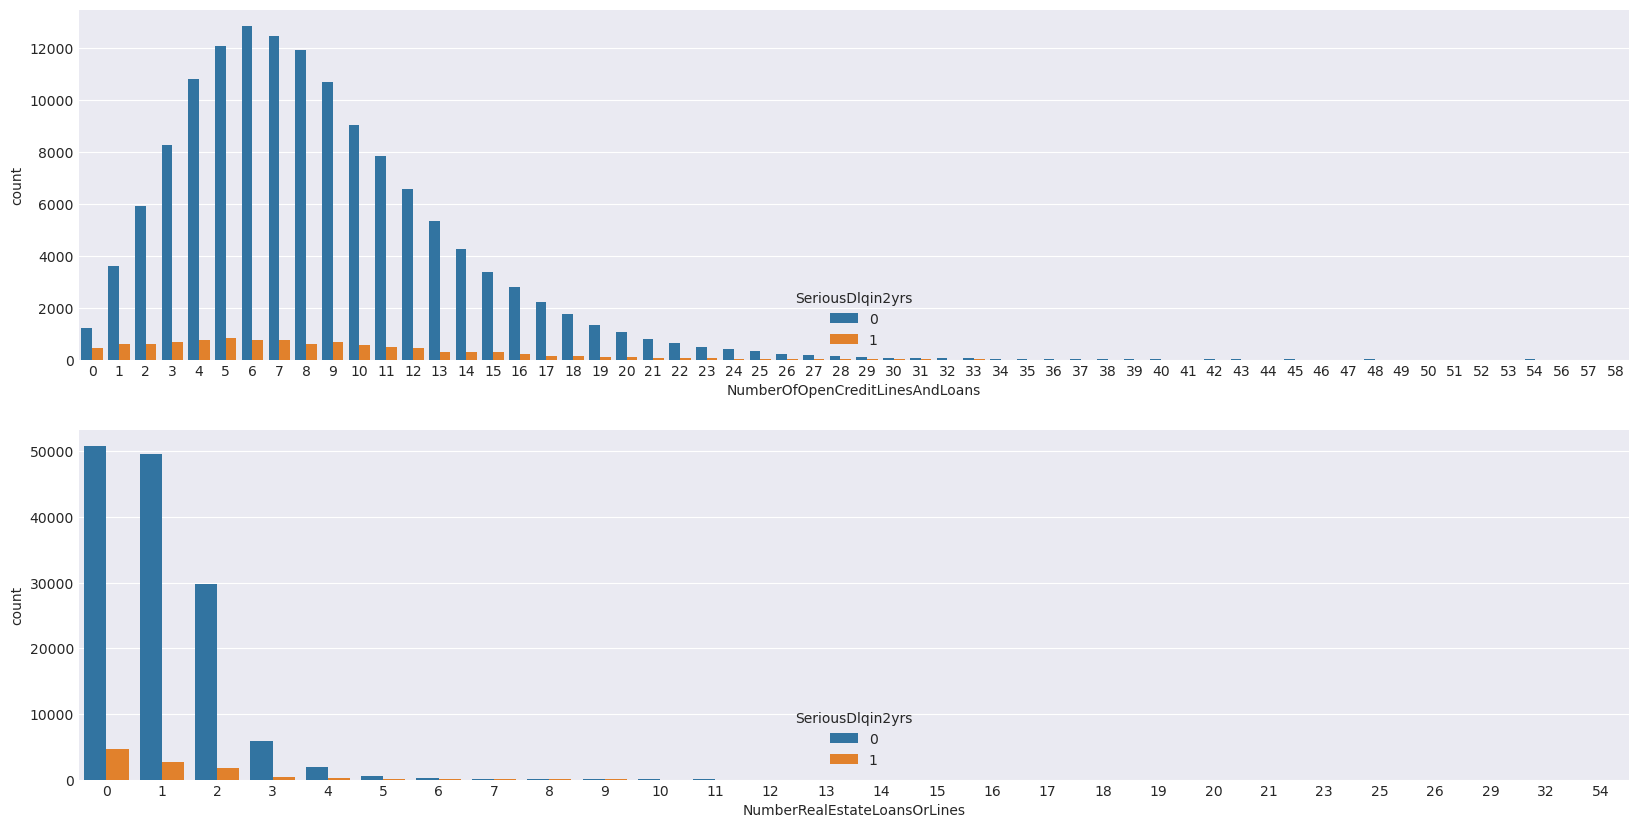

In [836]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['NumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['NumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

#### Итог: Исходя из представленных графиков я бы разбил общие кредиты на промежутки: 0-12 - Группа 1, 13-20 - Группа 2, 21 и более - Группа 3.

#### Кредиты на жилье на: 0-2 - Группа 1, 3 и более - Группа 2

In [837]:
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=0) & (df.NumberOfOpenCreditLinesAndLoans<=12), 'BinNumberOfOpenCreditLinesAndLoans']=1
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=13) & (df.NumberOfOpenCreditLinesAndLoans<=20), 'BinNumberOfOpenCreditLinesAndLoans']=2
df.loc[(df.NumberOfOpenCreditLinesAndLoans>=21), 'BinNumberOfOpenCreditLinesAndLoans']=3

In [838]:
df.loc[(df.NumberRealEstateLoansOrLines>=0) & (df.NumberRealEstateLoansOrLines<=2), 'BinNumberRealEstateLoansOrLines']=1
df.loc[(df.NumberRealEstateLoansOrLines>=3), 'BinNumberRealEstateLoansOrLines']=2

<AxesSubplot:xlabel='BinNumberRealEstateLoansOrLines', ylabel='count'>

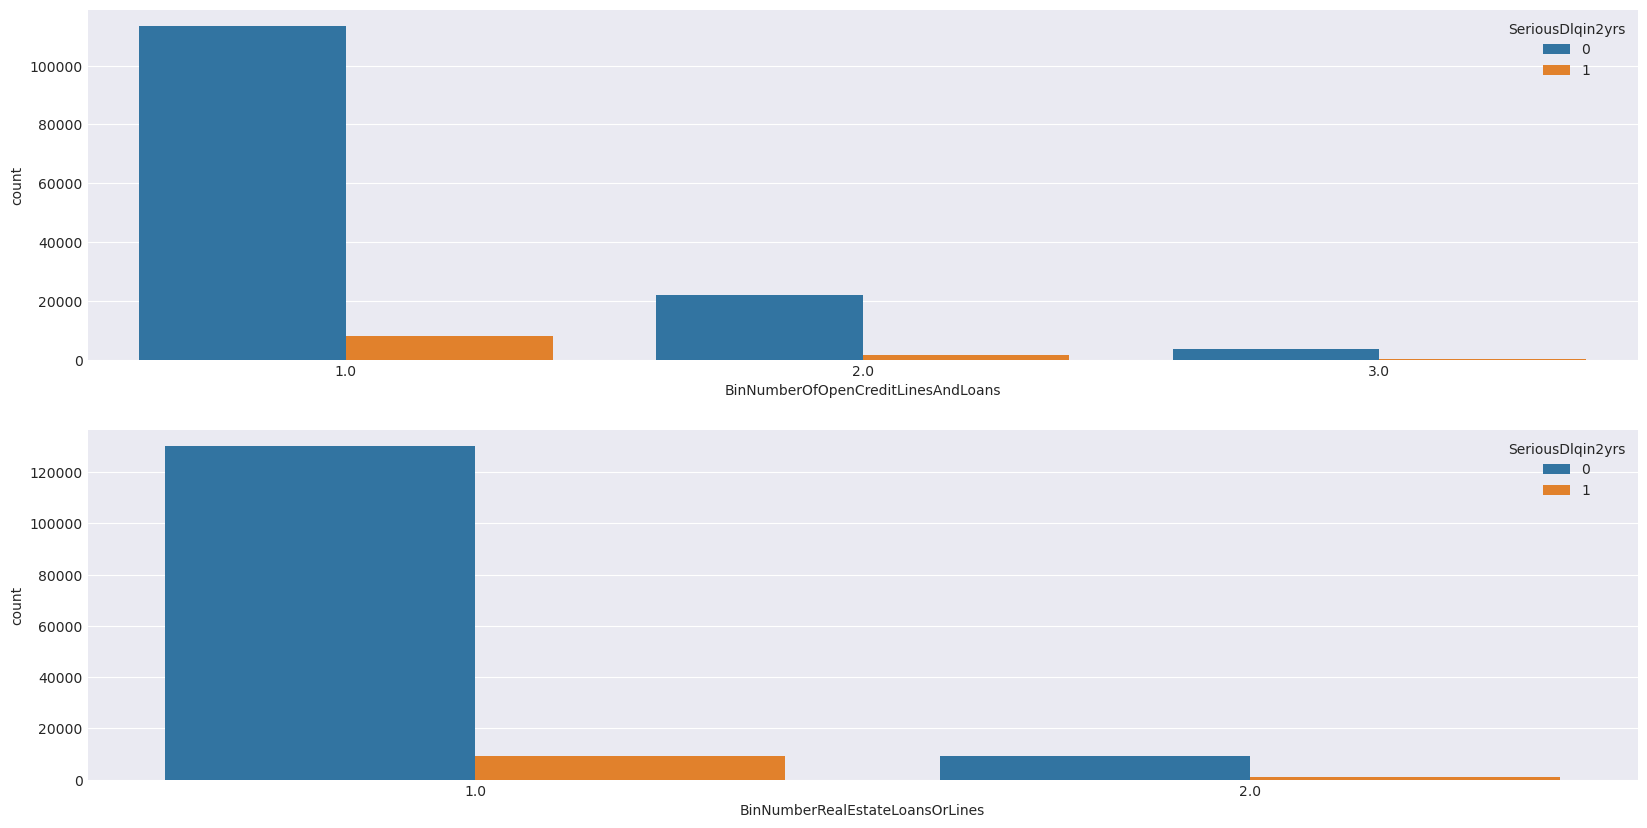

In [839]:
plt.figure(figsize=(20,10))

plt.subplot (2,1,1)
sns.countplot(x=df['BinNumberOfOpenCreditLinesAndLoans'], hue=df.SeriousDlqin2yrs)

plt.subplot (2,1,2)
sns.countplot(x=df['BinNumberRealEstateLoansOrLines'], hue=df.SeriousDlqin2yrs)

### V. Обучение после введения новых признаков

In [840]:
X=df.drop(['SeriousDlqin2yrs','NumberOfDependents','NumberOfOpenCreditLinesAndLoans','NumberRealEstateLoansOrLines'],axis=1)
y=df['SeriousDlqin2yrs']

In [841]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

##### 05.1. Логистическая регрессия

In [842]:
parameters = {"C":np.logspace(-3,3,7)}
pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(lr,parameters,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........................C=0.001;, score=0.935 total time=   0.1s
[CV 2/5] END ...........................C=0.001;, score=0.935 total time=   0.1s
[CV 3/5] END ...........................C=0.001;, score=0.935 total time=   0.1s
[CV 4/5] END ...........................C=0.001;, score=0.936 total time=   0.1s
[CV 5/5] END ...........................C=0.001;, score=0.935 total time=   0.1s
[CV 1/5] END ............................C=0.01;, score=0.935 total time=   0.3s
[CV 2/5] END ............................C=0.01;, score=0.935 total time=   0.2s
[CV 3/5] END ............................C=0.01;, score=0.935 total time=   0.1s
[CV 4/5] END ............................C=0.01;, score=0.937 total time=   0.1s
[CV 5/5] END ............................C=0.01;, score=0.936 total time=   0.1s
[CV 1/5] END .............................C=0.1;, score=0.936 total time=   0.1s
[CV 2/5] END .............................C=0.1;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=LogisticRegression(),
                              param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
                              verbose=3))])

In [843]:
pipeline.named_steps['gs'].best_params_

{'C': 1.0}

In [844]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])


0.81063787224492

##### 05.1. Случайный лес

In [845]:
param_grid = { 
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1,2,4]
}

pipeline = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("gs",GridSearchCV(rfc,param_grid,cv=5,verbose=3)
                     )])
pipeline.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   3.3s
[CV 2/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   3.2s
[CV 3/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   3.4s
[CV 4/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   3.6s
[CV 5/5] END ....max_depth=1, max_features=auto;, score=0.932 total time=   3.5s
[CV 1/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   3.5s
[CV 2/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   3.0s
[CV 3/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   3.2s
[CV 4/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   3.6s
[CV 5/5] END ....max_depth=1, max_features=sqrt;, score=0.932 total time=   3.3s
[CV 1/5] END ....max_depth=1, max_features=log2;, score=0.932 total time=   3.2s
[CV 2/5] END ....max_depth=1, max_features=log2;,

Pipeline(steps=[('scaler', StandardScaler()),
                ('gs',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'max_depth': [1, 2, 4],
                                          'max_features': ['auto', 'sqrt',
                                                           'log2']},
                              verbose=3))])

In [846]:
pipeline.named_steps['gs'].best_params_

{'max_depth': 4, 'max_features': 'auto'}

In [847]:
roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])

0.8555756340868027

#### Как улучшилось качество модели?

___После введения новых признаков логистическая регрессия улучшилась до 81.06. Касательно дерева решений - результат тоже несколько улучшился до 85.557___

## VI.  __Кривые валидации и обучения__

## 06.1. Кривая валидации

##### 06.1.1. Логистическая регрессия

In [848]:
c = np.logspace(-3,3,7)

lr_pipe = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("lr",LogisticRegression())
                     ])

val_train, val_test = validation_curve(estimator=lr_pipe, X=X, y=y,
                                       param_name='lr__C', param_range=c, cv=5,
                                       scoring='roc_auc')

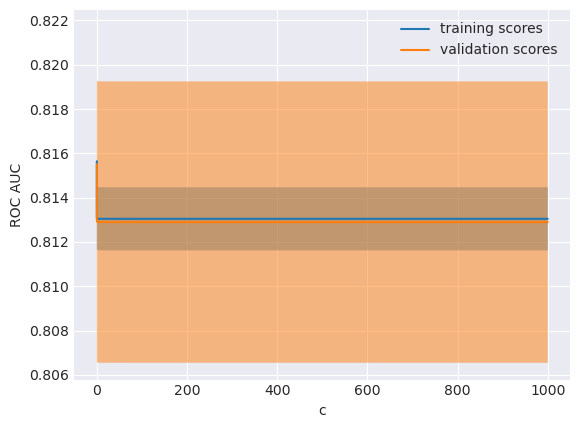

In [849]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.5)
plot_with_err(c, val_train, label='training scores')
plot_with_err(c, val_test, label='validation scores')
plt.xlabel('c'); plt.ylabel('ROC AUC')
plt.legend();

##### 06.1.2. Случайный лес 

In [850]:
max_depth=np.linspace(2,10,5)
rf_pipe = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("rf",RandomForestClassifier(max_features= 'log2'))
                     ])

val_train, val_test = validation_curve(estimator=rf_pipe, X=X, y=y,
                                       param_name='rf__max_depth', param_range=max_depth, cv=5,
                                       scoring='roc_auc')

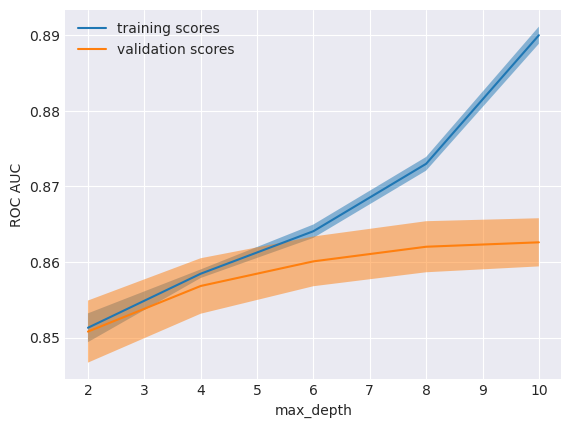

In [851]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.5)

plot_with_err(max_depth, val_train, label='training scores')
plot_with_err(max_depth, val_test, label='validation scores')
plt.xlabel('max_depth'); plt.ylabel('ROC AUC')
plt.legend();

## 06.2. Кривая обучения

In [852]:
def plot_learning_curve(N_train, val_train, val_test):
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('AUC')
    plt.legend()

##### 06.2.1. Логистическая регрессия

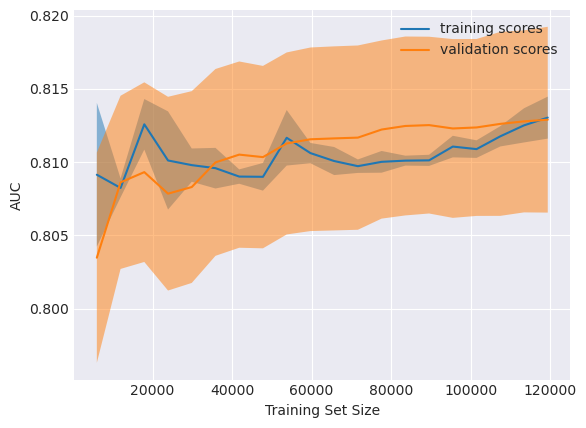

In [853]:
train_sizes = np.linspace(0.05, 1, 20)

lr_pipe = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("lr",LogisticRegression())
                     ])

N_train, val_train, val_test = learning_curve(lr_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')

plot_learning_curve(N_train, val_train, val_test)

##### 06.2.2. Случайный лес

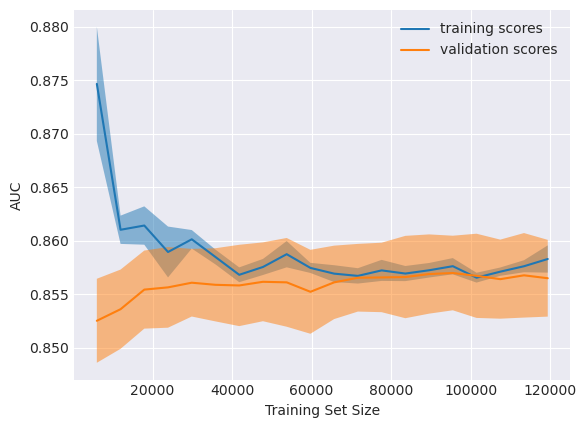

In [854]:
train_sizes = np.linspace(0.05, 1, 20)

rf_pipe = Pipeline([( "scaler" , StandardScaler()
                     ), 
                     ("rf",RandomForestClassifier(max_features= 'log2', max_depth=4))
                     ])

N_train, val_train, val_test = learning_curve(rf_pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
plot_learning_curve(N_train, val_train, val_test)

#### Какие наилучшие параметры модели по результатам построения? Как можно улучшить модель?

__Ответ: Увеличение сложности моделей в обоих случаях не приводит к улучшению результата на тренировочной выборке. Касательно размера модели мы видим разные результаты. Для логистической регрессии увеличение размера сета вроде как может привести к улучшению качества модели (хотя вряд ли), тогда как для случайного леса нет.__

### VII. __Общие выводы__

В результате проведенной работы проведен анализ данных, выполнена очистка набора данных, обработаны пропуски. Проведена визуальная оценка данных. Установлено, что на вероятность невозврата кредита влияет общее количество кредитов, а также количество кредитов не недвижимость. Причем на их количество в свою очередь влияет количество иждивенцев.

После построения validation_curve и learning_curve установлено, что дальнейшее усложнение выбранных моделей или увеличение набора данных на результат вряд ли сильно не повлияет. Чтобы улучшить показатели надо более досканально обработать первичный набор данных и ввести еще новые параметры.